In [1]:
import pandas as pd
import numpy as np
import os
import ast
import glob
import matplotlib.pyplot as plt

Key: ('100', '2000', '1', '1', '5', '1', '3', '400', 'hard cutoff', 'divide exposure singly', 'intrest', 'rate')


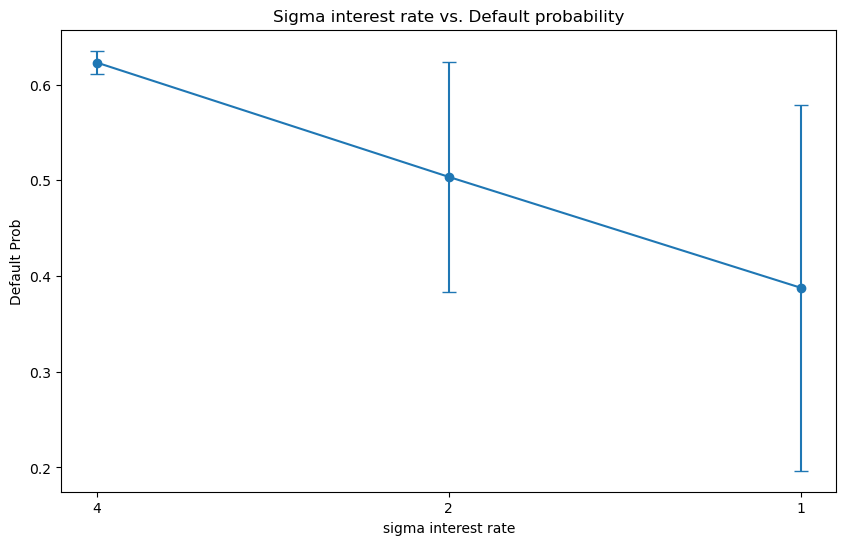

In [5]:
threshold = 3

def calculate_probability(num_list, threshold = 3):
    nums = len([i for i in num_list if i >= threshold])
    return nums / len(num_list)

def group_files(directory: str = './'):
    grouped_files = {}
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            parts = filename.split('_')
            key = tuple(parts[:4] + parts[5:-1])
            if key not in grouped_files:
                grouped_files[key] = {'filenames': [], 'sigma_interest_rates': []}
            grouped_files[key]['filenames'].append(filename)
            grouped_files[key]['sigma_interest_rates'].append(parts[4])
    return grouped_files

groups = group_files()

for key, value in groups.items():
    print("Key:", key)
    bankrupt_nodes = []
    bankrupt_nodes_avg_list = []
    bankrupt_nodes_std_list = []
    filenames = value['filenames']
    sigmas = value['sigma_interest_rates']
    for filename in filenames:
        df = pd.read_csv(filename)
        for i in range(len(df)):
            if pd.isna(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]) or pd.isna(df['Number of Bankrupt Agents Over Time'].iloc[i]):
                continue
            else: 
                bankrupt_node = calculate_probability(ast.literal_eval(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]), threshold = threshold)
                bankrupt_nodes.append(bankrupt_node)
        bankrupt_nodes_avg = np.mean(bankrupt_nodes)
        bankrupt_nodes_avg_list.append(bankrupt_nodes_avg)
        bankrupt_nodes_std = np.std(bankrupt_nodes)
        bankrupt_nodes_std_list.append(bankrupt_nodes_std)
      
        
    plt.figure(figsize=(10, 6))
    plt.errorbar(sigmas, bankrupt_nodes_avg_list, yerr=bankrupt_nodes_std_list, fmt='-o', capsize=5)
    plt.xlabel('sigma interest rate')
    plt.ylabel('Default Prob')
    plt.title('Avalanche Prob vs. Volatility')
    plt.show()